In [ ]:
import numpy as np
from matplotlib import pyplot as plt

# Environment

In [ ]:
class Environment:
    def __init__(self):
        self.seperator_char = "-"
        self.volunteer = 50
        prob_junior_recruitment = {"social_net":0.8, "env_adv":0.3, "job_adv":0.5}
        prob_mid_recruitment = {"social_net":0.5, "env_adv":0.5, "job_adv":0.6}
        prob_senior_recruitment = {"social_net":0.2, "env_adv":0.7, "job_adv":0.8}

        self.recruitment_matrix = {"junior":prob_junior_recruitment,
                                "mid":prob_mid_recruitment,
                                "senior":prob_senior_recruitment
                            }
        self.learning_cost = {"junior":8, "mid":6, "senior":3}

        self.prob_industry_recruitment = {"junior":0.7, "mid":0.5, "senior":0.3}
        self.company_income = {"junior":27, "mid":26, "senior":25}
        self.company_cost = {"social_net":2, "env_adv":14, "job_adv":10}
        self.all_actions = {f'{row}-{col}': value for row, cols in self.recruitment_matrix.items() for col, value in cols.items()}
        self.action_2_idx = {action:i for i, action in enumerate(self.all_actions.keys())}
        self.idx_2_action = {i:action for i, action in enumerate(self.all_actions.keys())}
        self.first_reward = self._calc_first_rewards()
        #print(self.first_reward)

    def is_course_holding(self, degree:str, adv_method:str):
        hold_class_prob  = self.recruitment_matrix[degree][adv_method]
        if np.random.rand() < hold_class_prob:
            return True
        return False


    def reward_function(self, chosen_action_idx, initialization=False):
        chosen_action_key = self.idx_2_action[chosen_action_idx]
        degree = chosen_action_key.split(self.seperator_char)[0]
        adv_method = chosen_action_key.split(self.seperator_char)[1]
        if initialization:
            hold_class_prob  = self.recruitment_matrix[degree][adv_method]
            init_reward = hold_class_prob*10*self.prob_industry_recruitment[degree]*self.company_income[degree] - 10*self.learning_cost[degree] - self.company_cost[adv_method]
            return init_reward
        if self.is_course_holding(degree, adv_method):
            prob_recruitment = self.prob_industry_recruitment[degree]
            numb_of_industry_recu = int(10*prob_recruitment)
            final_reward = numb_of_industry_recu*(self.company_income[degree]) - 10*self.learning_cost[degree] -  self.company_cost[adv_method]
        else:
            final_reward = -1*self.company_cost[adv_method]
        return final_reward

    def _calc_first_rewards(self):
        first_rewards = np.zeros(len(self.all_actions))
        for action in list(self.all_actions.keys()):
            idx = self.action_2_idx[action]
            first_rewards[idx] = self.reward_function(idx,initialization=True)

        return first_rewards

    def get_optimal_action_idx(self):
        return np.argmax(self.first_reward)




# Utils

In [ ]:
def compute_regret(optimal_action, chosen_action, bandit_means):
    optimal_reward = bandit_means[optimal_action]
    actual_reward = bandit_means[chosen_action]
    return optimal_reward - actual_reward

# Epsilon Greedy

In [ ]:
def epsilon_greedy(Q, epsilon):
    return np.random.choice(len(Q)) if np.random.rand() < epsilon  else np.argmax(Q)

def update_q_value(Q, action_idx, reward, alpha):
    Q[action_idx] = Q[action_idx] + alpha * (reward - Q[action_idx])
    return Q

def epsilon_greedy_simulation(num_steps, epsilon, env):
    all_actions = env.all_actions
    bandit_means = env.first_reward
    true_optimal_action = env.get_optimal_action_idx()
    Q_values = np.zeros(len(all_actions))
    action_counts = np.zeros(len(all_actions))
    rewards = []
    regret_values = []
    for step in range(num_steps):
        chosen_action = epsilon_greedy(Q_values, epsilon)
        reward = env.reward_function(chosen_action)
        alpha = 1/action_counts[chosen_action]
        Q_values = update_q_value(Q_values, chosen_action, reward, alpha)
        rewards.append(reward)
        regret = compute_regret(true_optimal_action, chosen_action, bandit_means)
        regret_values.append(regret)
        action_counts[chosen_action] += 1
    return rewards, action_counts, true_optimal_action, regret_values


# UCB

In [ ]:

def compute_regret(optimal_action, chosen_action, bandit_means):
    optimal_reward = bandit_means[optimal_action]
    actual_reward = bandit_means[chosen_action]
    return optimal_reward - actual_reward

def ucb(Q_values, action_counts, step):
    exploration_term = np.sqrt(2 * np.log(step + 1) / (action_counts + 1e-6))
    ucb_values = Q_values + 2*exploration_term
    return np.argmax(ucb_values)
def update_q_value_and_counts(Q, action, reward, action_counts):
    Q[action] = Q[action] + (reward - Q[action]) / (action_counts[action] + 1)
    action_counts[action] += 1
    return Q, action_counts
def ucb_simulation_with_metrics(num_steps, env):
    all_actions = env.all_actions
    bandit_means =env.first_reward
    true_optimal_action = env.get_optimal_action_idx()
    Q_values = np.zeros(len(all_actions))
    action_counts = np.zeros(len(all_actions))
    regret_values = []
    reward_values = []
    for step in range(num_steps):
        chosen_action = ucb(Q_values, action_counts, step)
        reward =  env.reward_function(chosen_action)
        Q_values, action_counts = update_q_value_and_counts(Q_values, chosen_action, reward, action_counts)
        regret = compute_regret(true_optimal_action, chosen_action, bandit_means)
        regret_values.append(regret)
        reward_values.append(reward)
    return reward_values, action_counts, true_optimal_action, regret_values


# Runs



In [ ]:
def calc_upper_lower_bounds(regrets: list):
    runs_no = len(regrets)
    mean_regret = np.mean(np.array(regrets), axis=0)
    std_regret = np.std(np.array(regrets), axis=0)
    upper_bound = mean_regret + 1.96 * std_regret / np.sqrt(runs_no)
    lower_bound = mean_regret - 1.96 * std_regret / np.sqrt(runs_no)

    return mean_regret, std_regret ,upper_bound, lower_bound

def plot_regret(greedy_regrets:list, ucb_regrets:list):
    # Calculate the mean and standard deviation of the regret sequences
    mean_regret_greedy, std_regret_greedy ,upper_bound_greedy, lower_bound_greedy = calc_upper_lower_bounds(greedy_regrets)
    mean_regret_ucb, std_regret_ucb ,upper_bound_ucb, lower_bound_ucb = calc_upper_lower_bounds(ucb_regrets)
    # Plot the mean regret and confidence interval
    fig, ax = plt.subplots()
    ax.plot(mean_regret_greedy, label="Mean Regret Epsilon Greedy")
    #ax.fill_between(np.arange(len(mean_regret_greedy)), lower_bound_greedy ,upper_bound_greedy , alpha=0.5, label= "Epsilon Greedy")
    ax.plot(mean_regret_ucb, label="Mean Regret UCB")
    #ax.fill_between(np.arange(len(mean_regret_ucb)), lower_bound_ucb ,upper_bound_ucb , alpha=0.5, label= "UCB")
    # Set the title and labels
    ax.set_title(f"Mean Regret of 10 Run")
    ax.set_xlabel("Horizon")
    ax.set_ylabel("Regret")
    plt.legend()
    # Show the plot
    plt.show()


def plot_reward(greedy_rewards:list, ucb_rewards:list):
    # Calculate the mean and standard deviation of the regret sequences
    mean_reward_greedy, std_reward_greedy ,upper_bound_greedy, lower_bound_greedy = calc_upper_lower_bounds(greedy_rewards)
    mean_reward_ucb, std_reward_ucb ,upper_bound_ucb, lower_bound_ucb = calc_upper_lower_bounds(ucb_rewards)
    # Plot the mean regret and confidence interval
    fig, ax = plt.subplots()
    ax.plot(mean_reward_greedy, label="Mean Reward Epsilon Greedy")
    #ax.fill_between(np.arange(len(mean_regret_greedy)), lower_bound_greedy ,upper_bound_greedy , alpha=0.5, label= "Epsilon Greedy")
    ax.plot(mean_reward_ucb, label="Mean Reward UCB")
    #ax.fill_between(np.arange(len(mean_regret_ucb)), lower_bound_ucb ,upper_bound_ucb , alpha=0.5, label= "UCB")

    # Set the title and labels
    ax.set_title(f"Mean Reward of 10 Run")
    ax.set_xlabel("Horizon")
    ax.set_ylabel("reward")
    plt.legend()
    plt.show()


def run_algorithm_in_10_city():
    greedy_all_regret_values = []
    ucb_all_regret_values = []
    greedy_all_reward_values = []
    ucb_all_reward_values = []
    env_simulation = Environment()
    for i in range(10):
        rewards, action_counts, true_optimal_action, regret_values = epsilon_greedy_simulation(num_steps = 520, epsilon = 0.1, env= env_simulation)
        greedy_all_regret_values.append(np.cumsum(regret_values))
        greedy_all_reward_values.append(np.cumsum(rewards))

    for i in range(10):
        reward_values, action_counts, true_optimal_action, regret_values = ucb_simulation_with_metrics(num_steps = 520, env= env_simulation)
        ucb_all_regret_values.append(np.cumsum(regret_values))
        ucb_all_reward_values.append(np.cumsum(reward_values))
    plot_regret(greedy_all_regret_values, ucb_all_regret_values)
    plot_reward(greedy_all_reward_values,ucb_all_reward_values)



<ipython-input-59-aa7a24777e2d>:19: RuntimeWarning: divide by zero encountered in double_scalars
  alpha = 1/action_counts[chosen_action]
<ipython-input-59-aa7a24777e2d>:5: RuntimeWarning: invalid value encountered in double_scalars
  Q[action_idx] = Q[action_idx] + alpha * (reward - Q[action_idx])


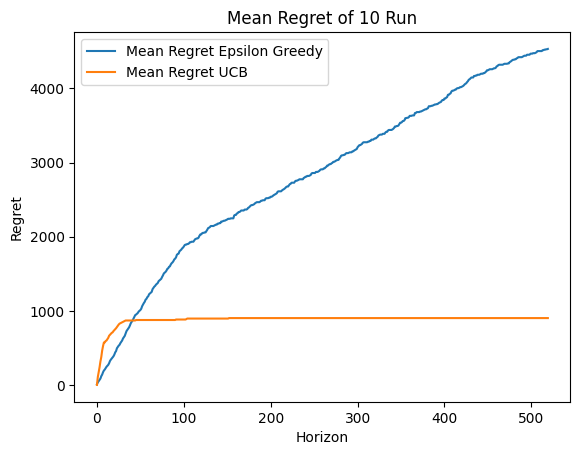

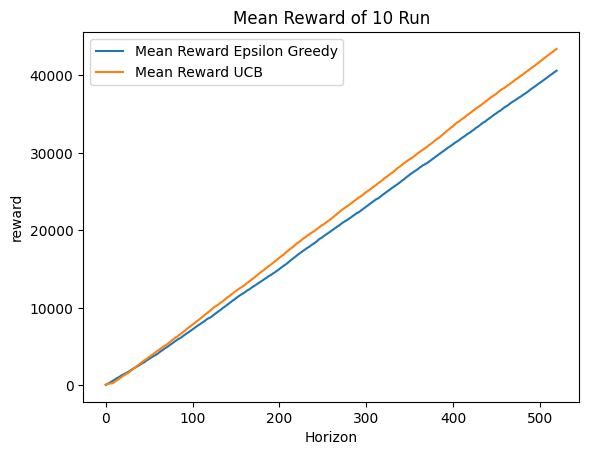

In [ ]:
run_algorithm_in_10_city()